<a href="https://colab.research.google.com/github/Karasiari/GraphMCF/blob/main/GeneratingDemandsResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-8zmb5wcn
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-8zmb5wcn
  Resolved https://github.com/Karasiari/graphmcf.git to commit 0f17dd368b8adc3598ae9100bd8b24d5cab554ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=25241 sha256=3c0614d25b0704a4f97d61d39528e4ac8d198034cc9a5a3f6a6bf02a9dfb019f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbgxl0h6/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [3]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [4]:
small_graphs_for_mcf = []
small_names = []
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8', '2024_north', '2024_south', '2024_southwest']
Small_Graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)
for name, graph_data in Small_Graphs_for_test.items():
    small_graphs_for_mcf.append(graph_data['adj_matrix'])
    small_names.append(name)


=== СВОДКА ПО ГРАФУ cola_t10 ===
Вершины: 83
epsilon: 0.025
Среднее initial_alpha: 0.2092
Сошедшихся запусков: 5 из 18 (27.78%)


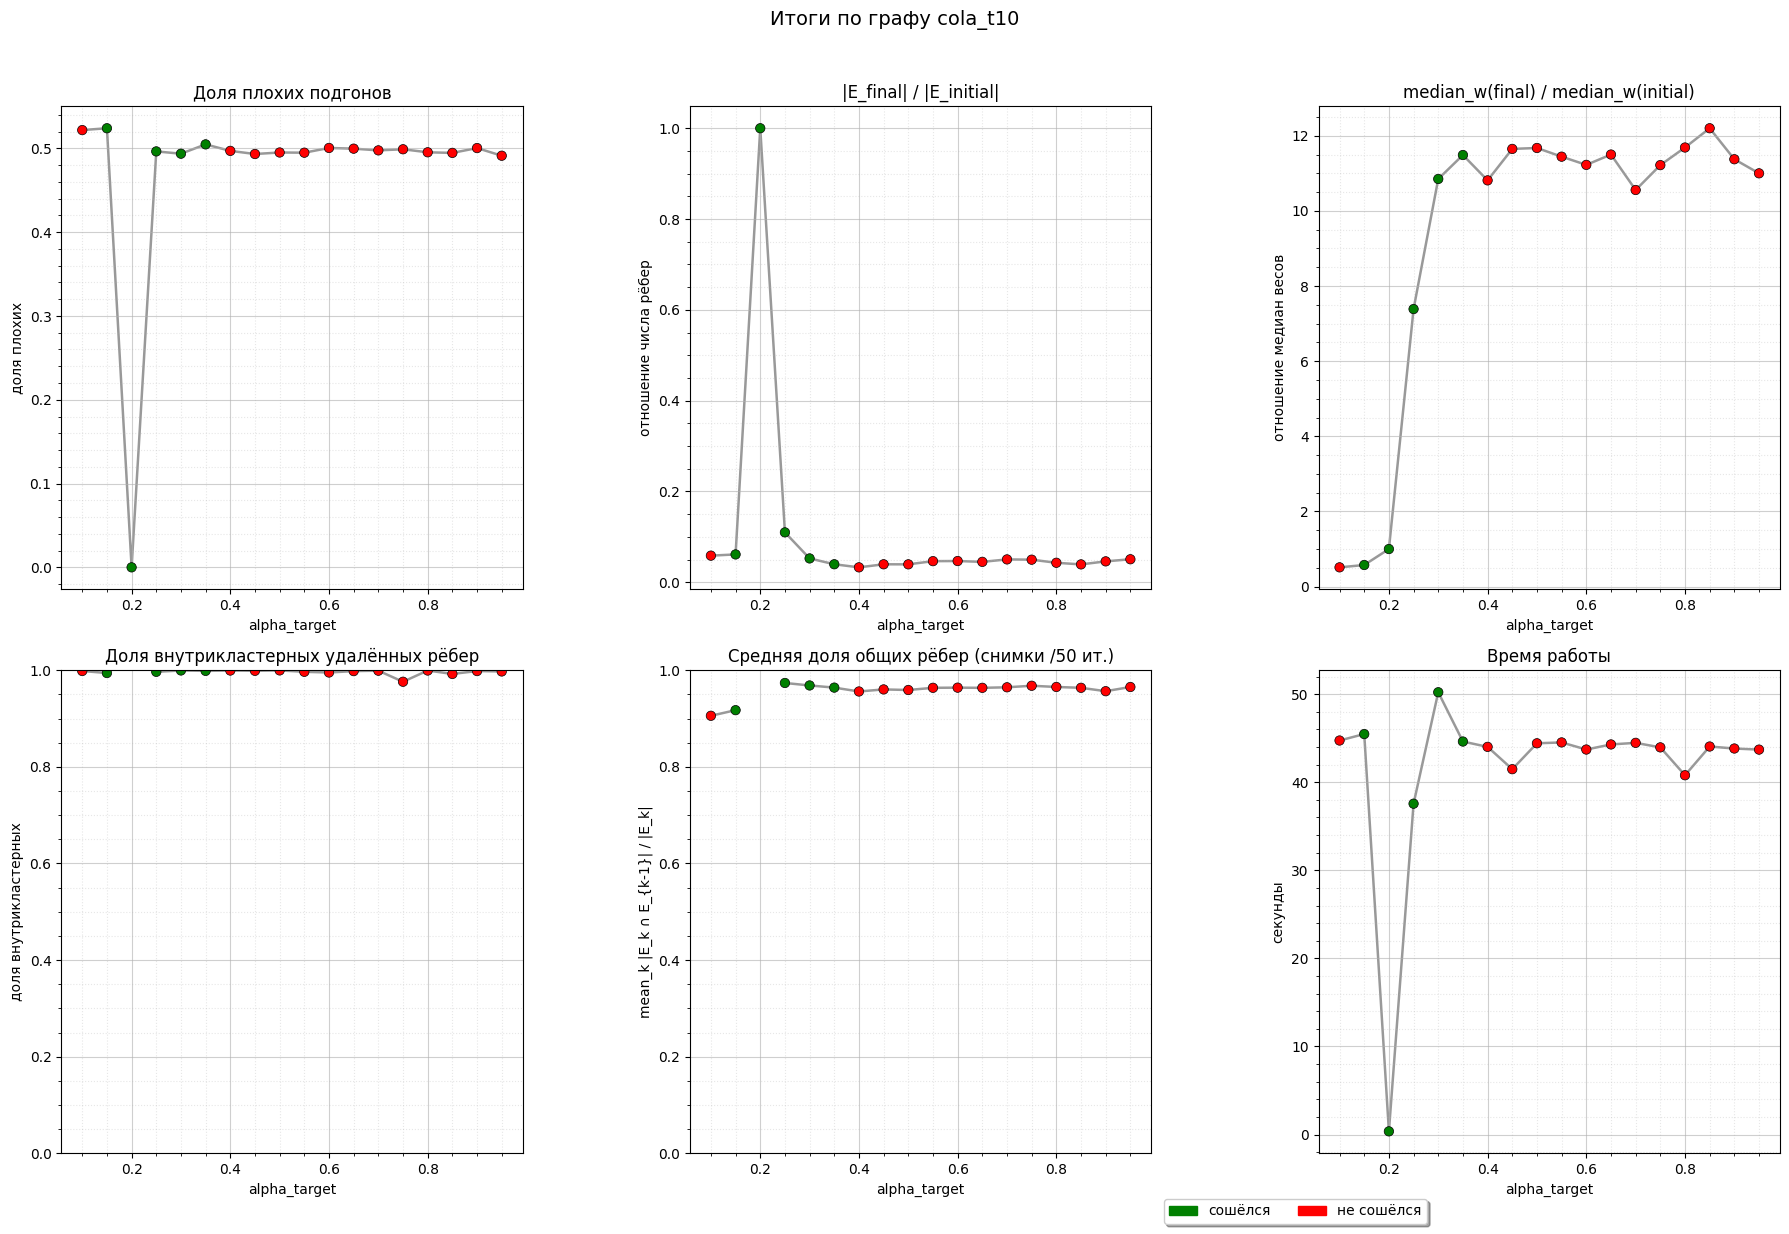


=== СВОДКА ПО ГРАФУ cola_t3 ===
Вершины: 21
epsilon: 0.025
Среднее initial_alpha: 0.2666
Сошедшихся запусков: 15 из 18 (83.33%)


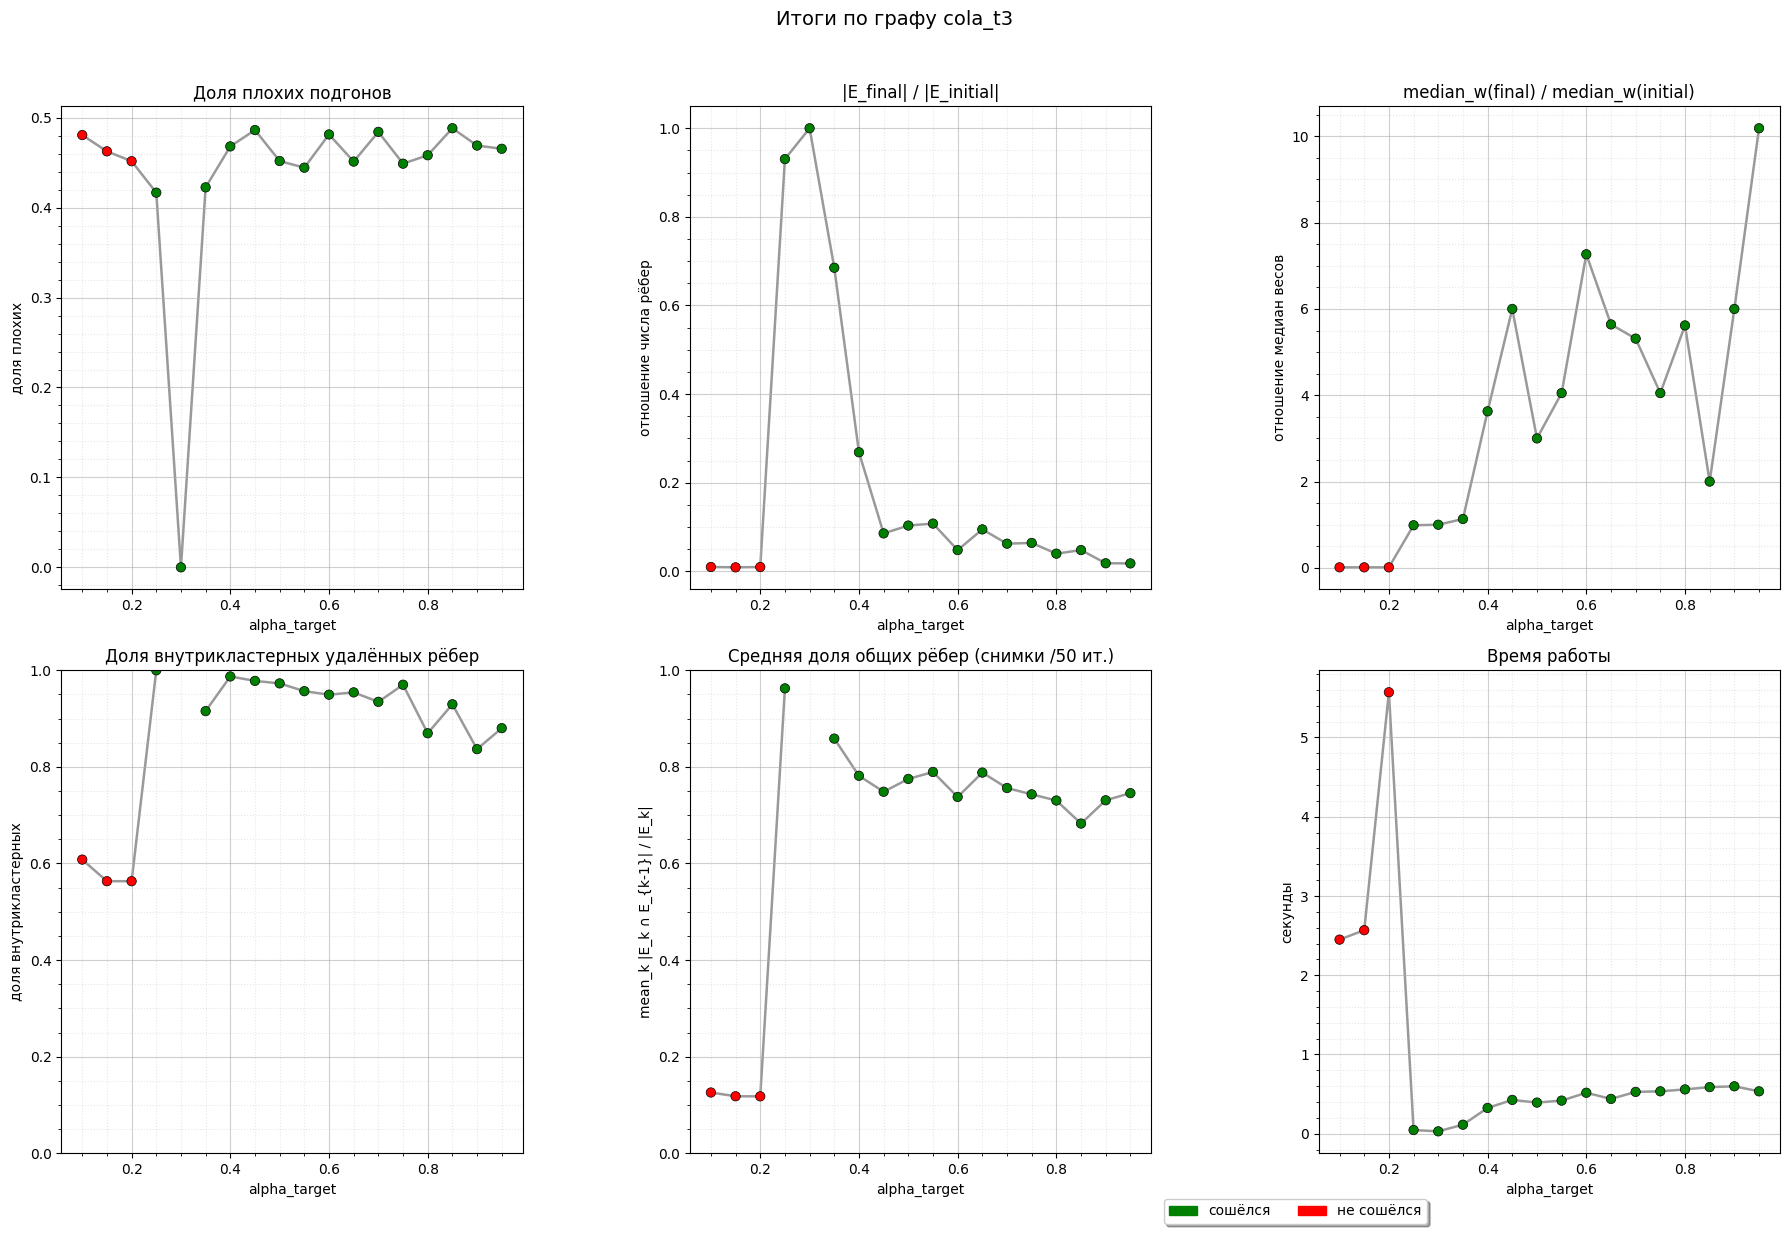


=== СВОДКА ПО ГРАФУ cola_t8 ===
Вершины: 54
epsilon: 0.025
Среднее initial_alpha: 0.3318
Сошедшихся запусков: 13 из 18 (72.22%)


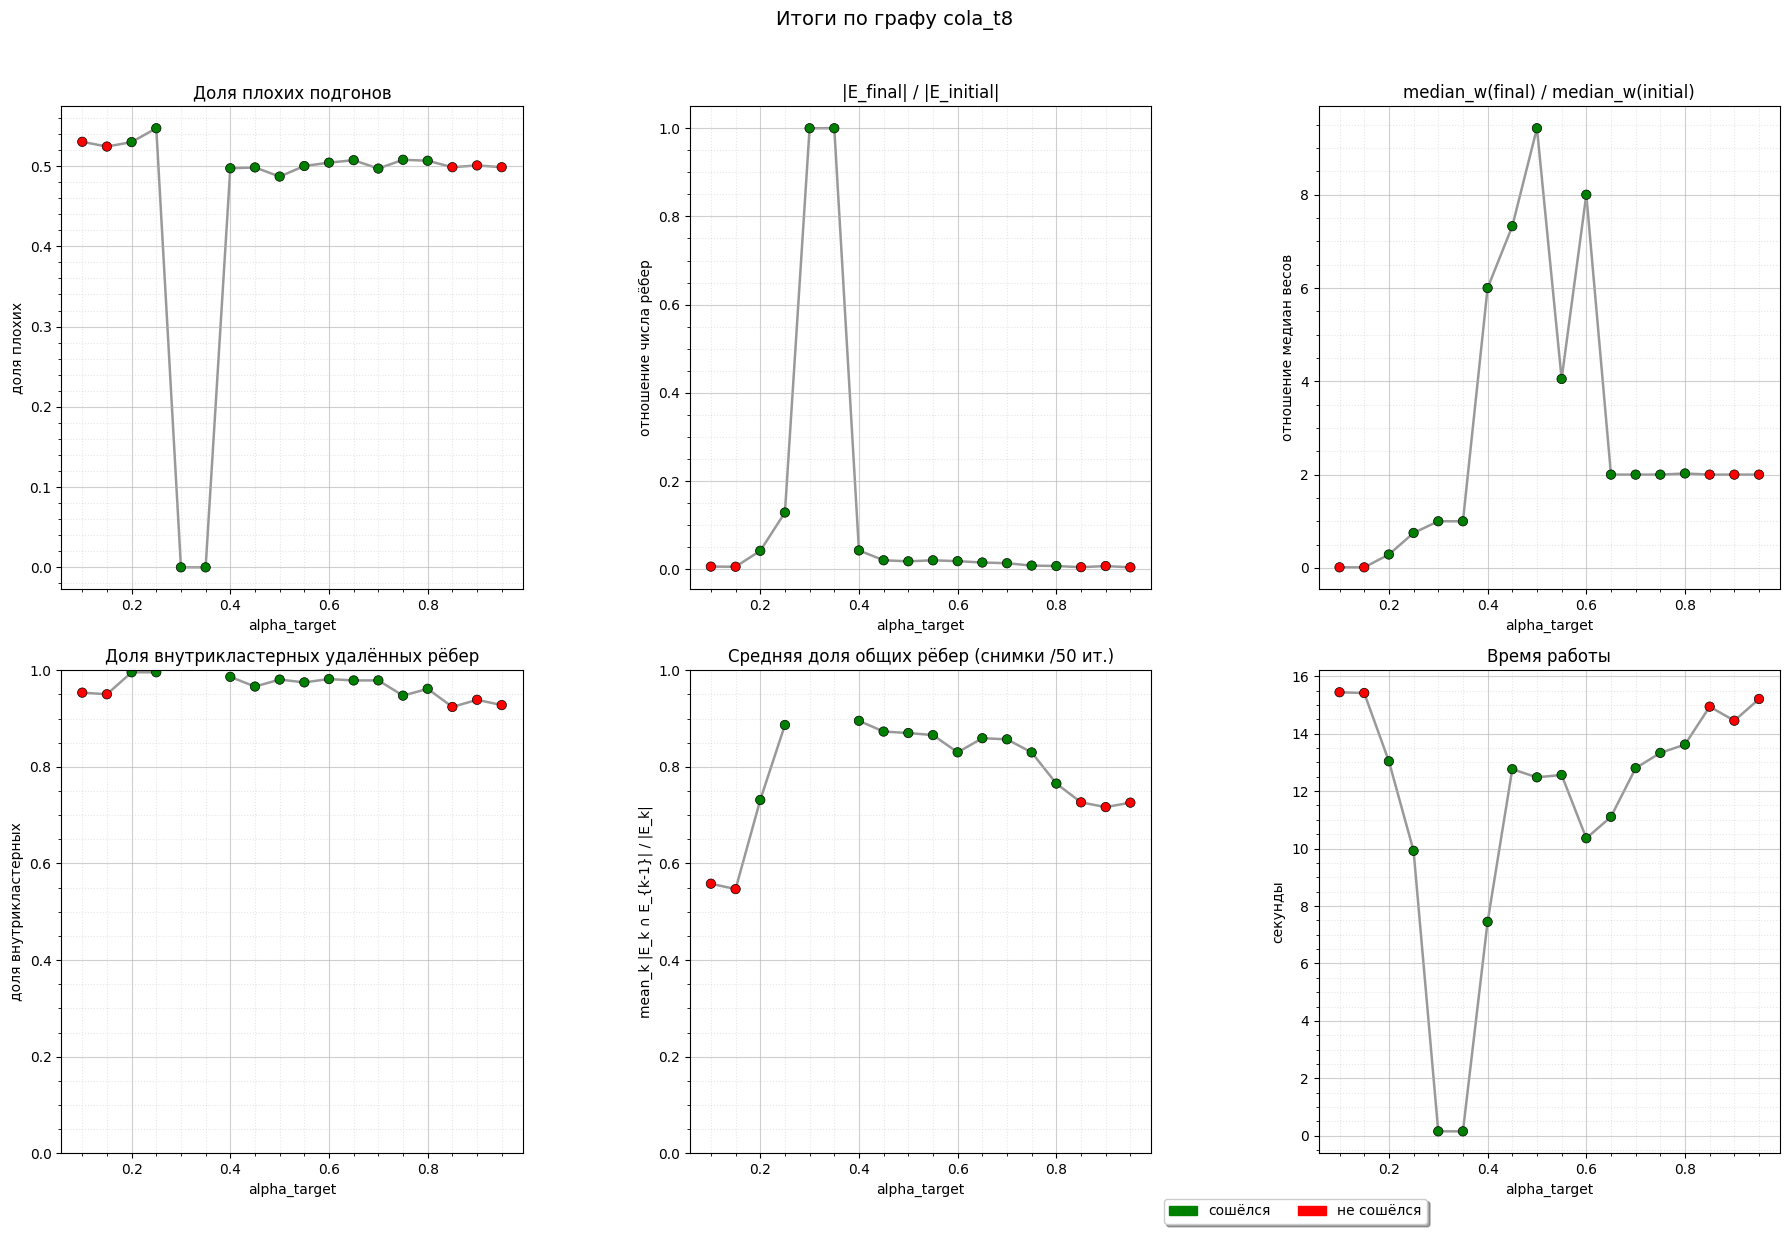


=== СВОДКА ПО ГРАФУ cola_t2 ===
Вершины: 32
epsilon: 0.025
Среднее initial_alpha: 0.1967
Сошедшихся запусков: 17 из 18 (94.44%)


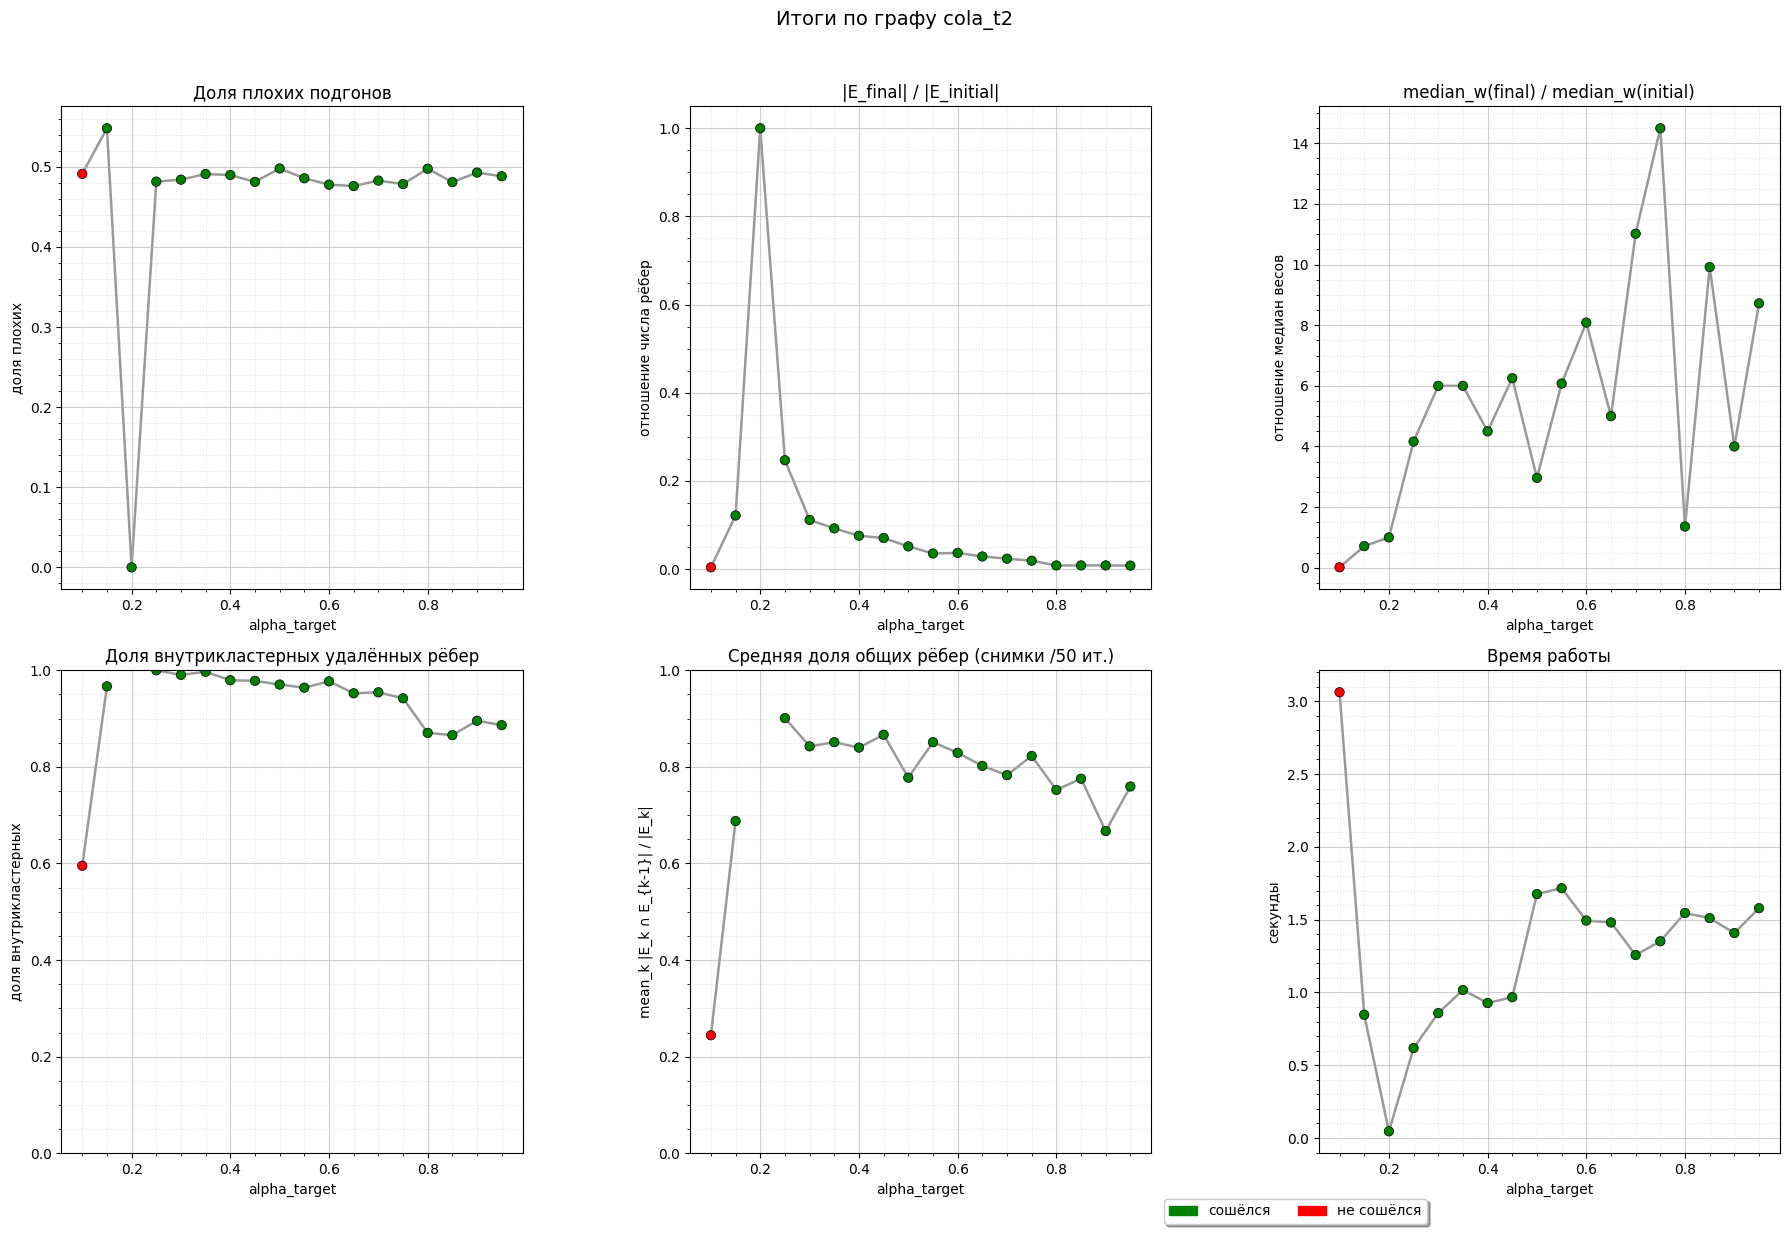


=== СВОДКА ПО ГРАФУ 2024_southwest ===
Вершины: 50
epsilon: 0.025
Среднее initial_alpha: 0.2608
Сошедшихся запусков: 14 из 18 (77.78%)


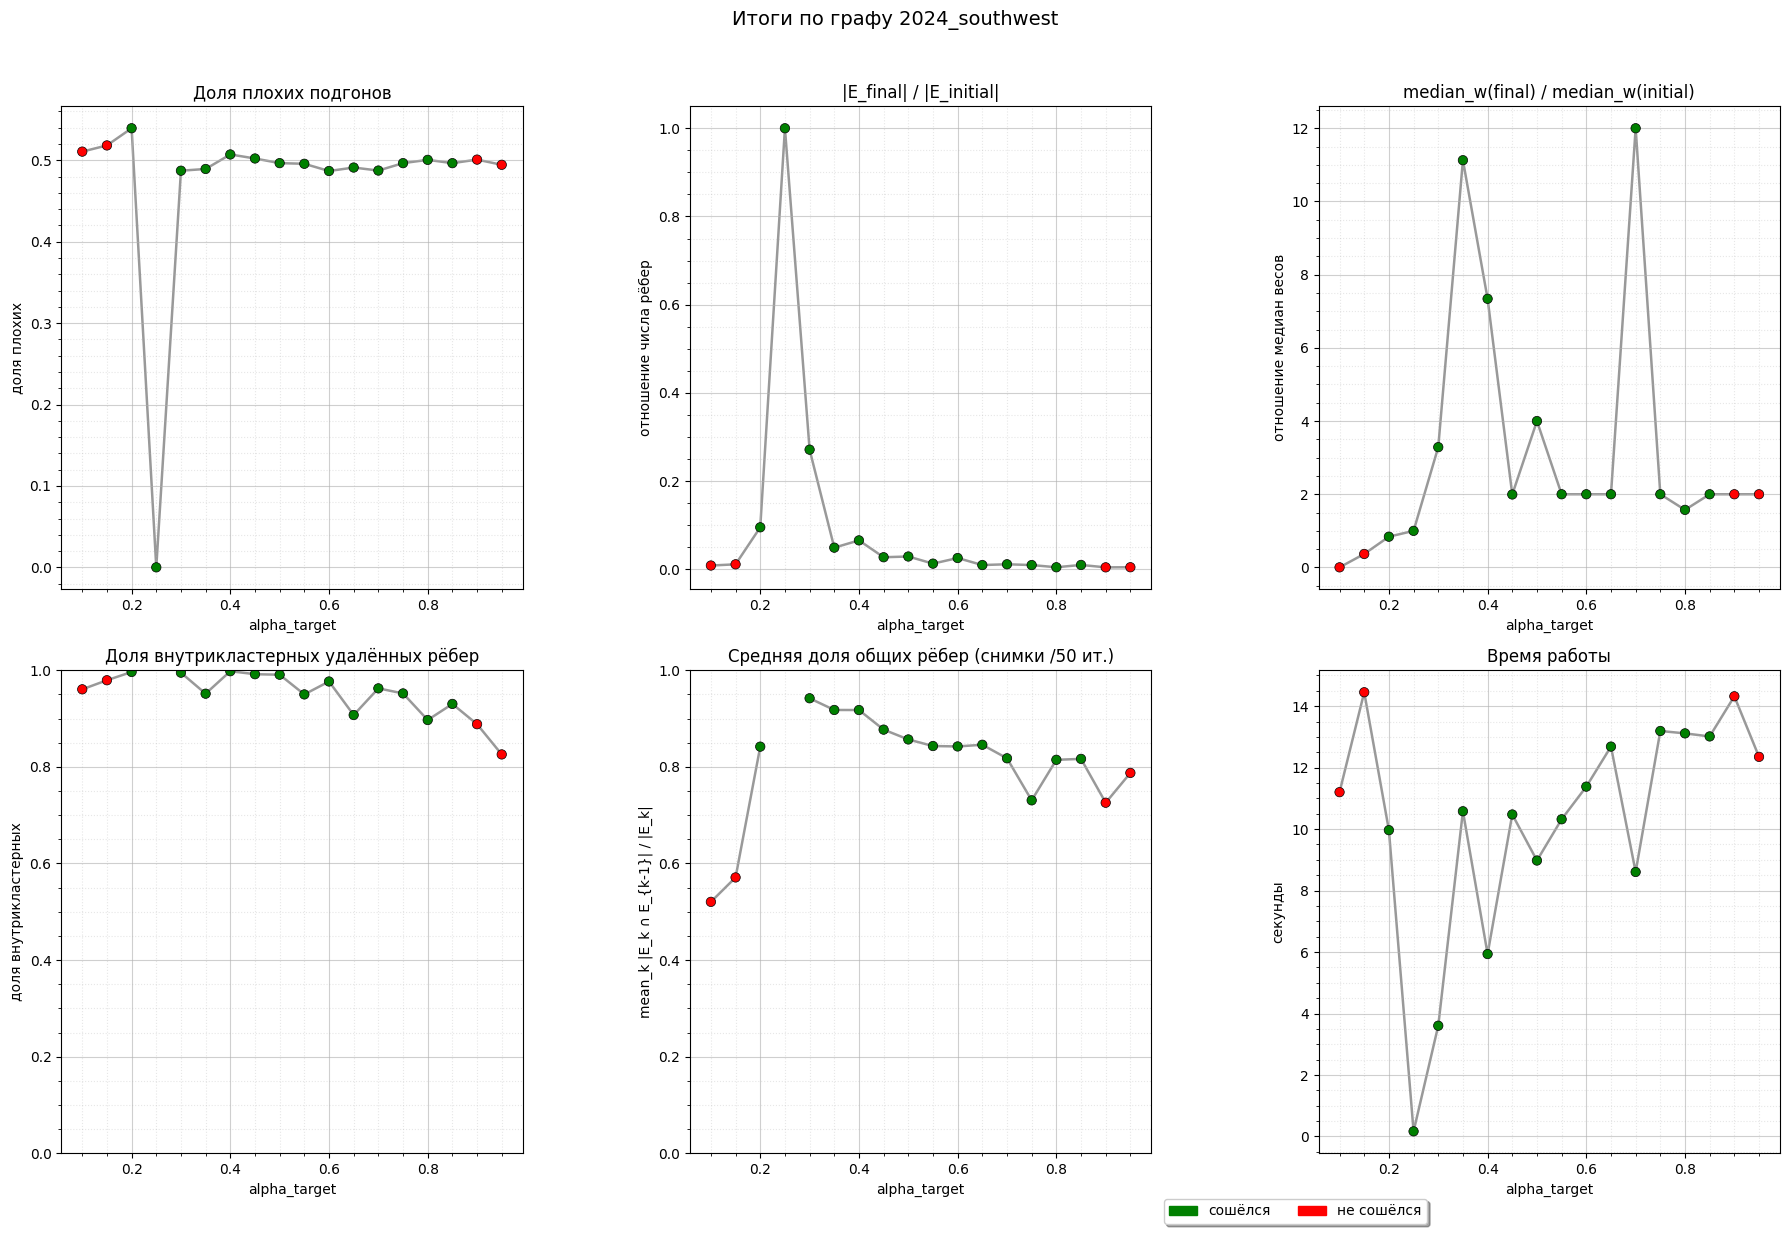


=== СВОДКА ПО ГРАФУ 2024_south ===
Вершины: 73
epsilon: 0.025
Среднее initial_alpha: 0.2353
Сошедшихся запусков: 3 из 18 (16.67%)


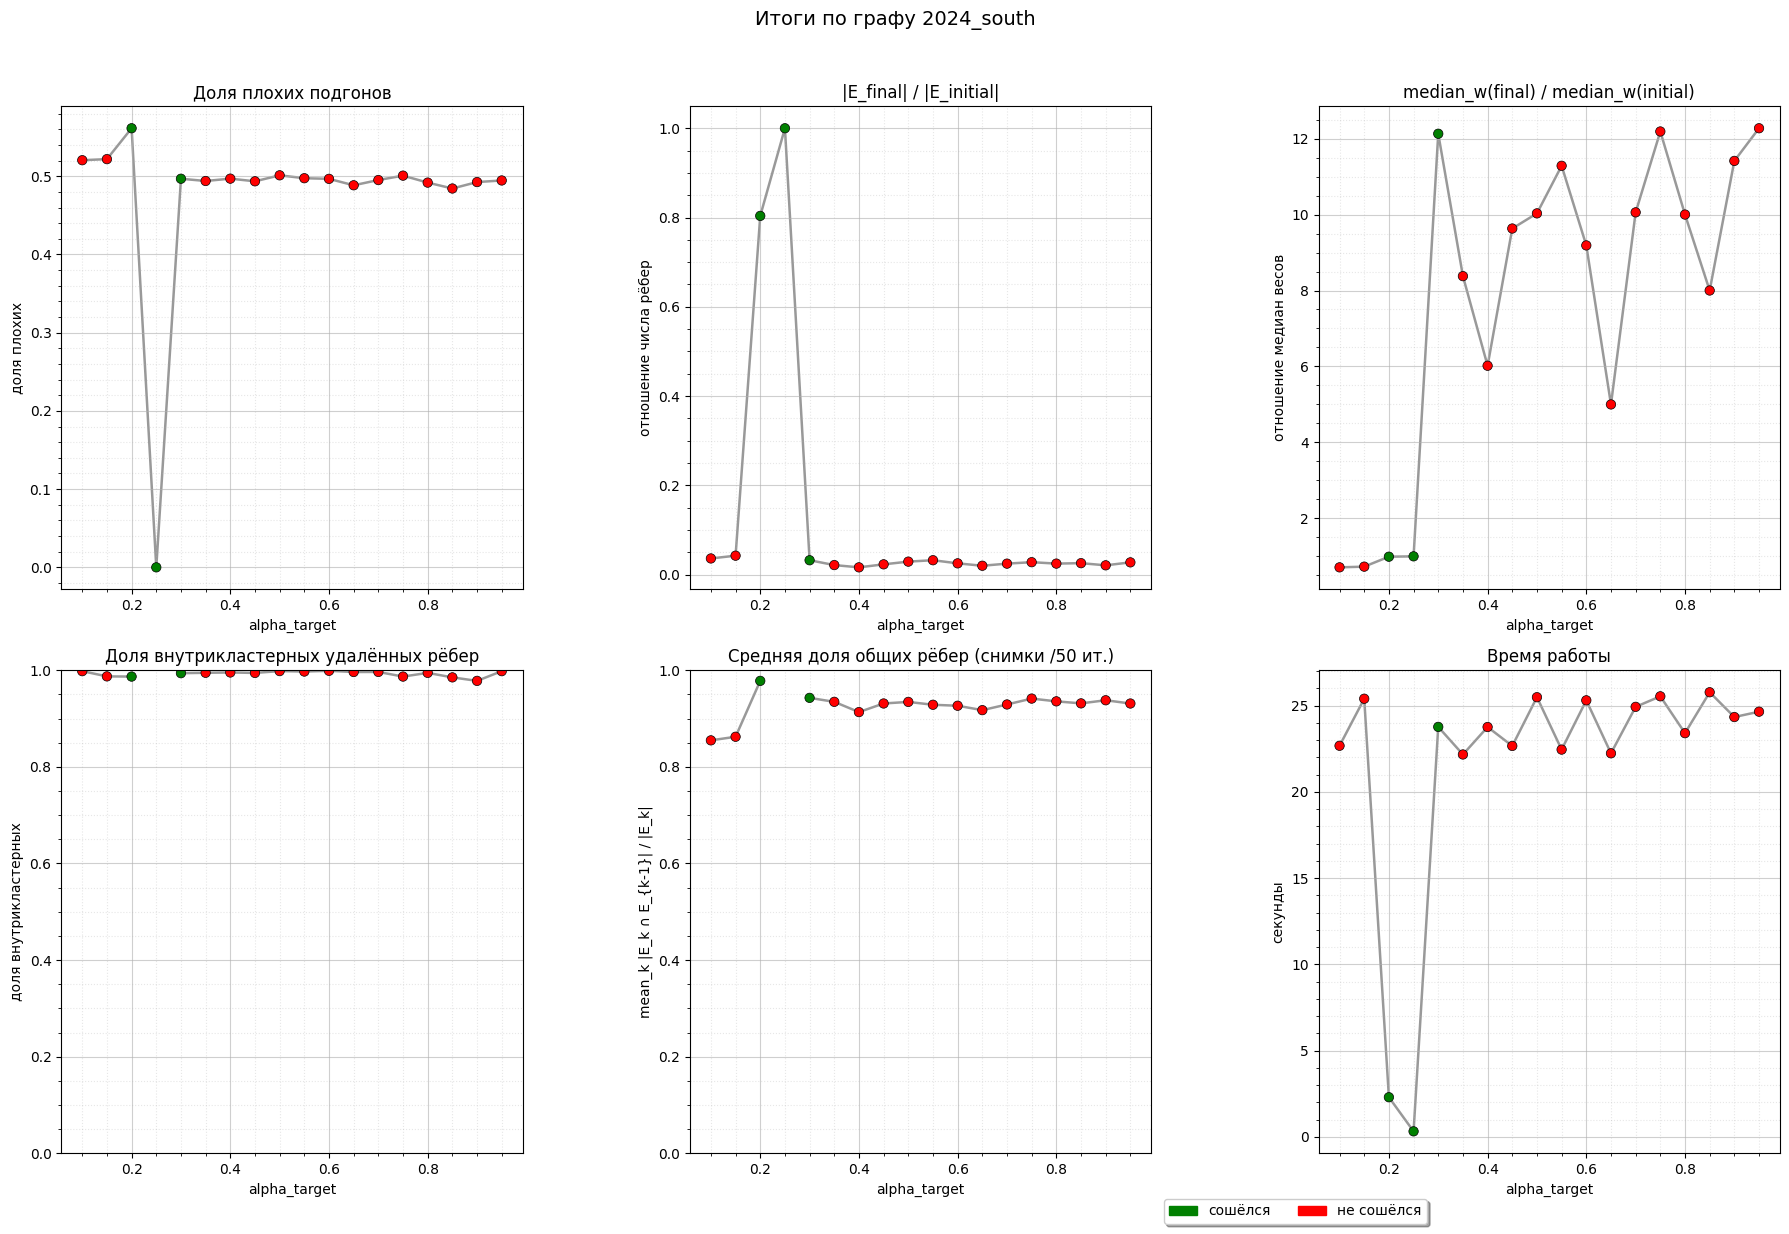


=== СВОДКА ПО ГРАФУ 2024_north ===
Вершины: 73
epsilon: 0.025
Среднее initial_alpha: 0.2274
Сошедшихся запусков: 4 из 18 (22.22%)


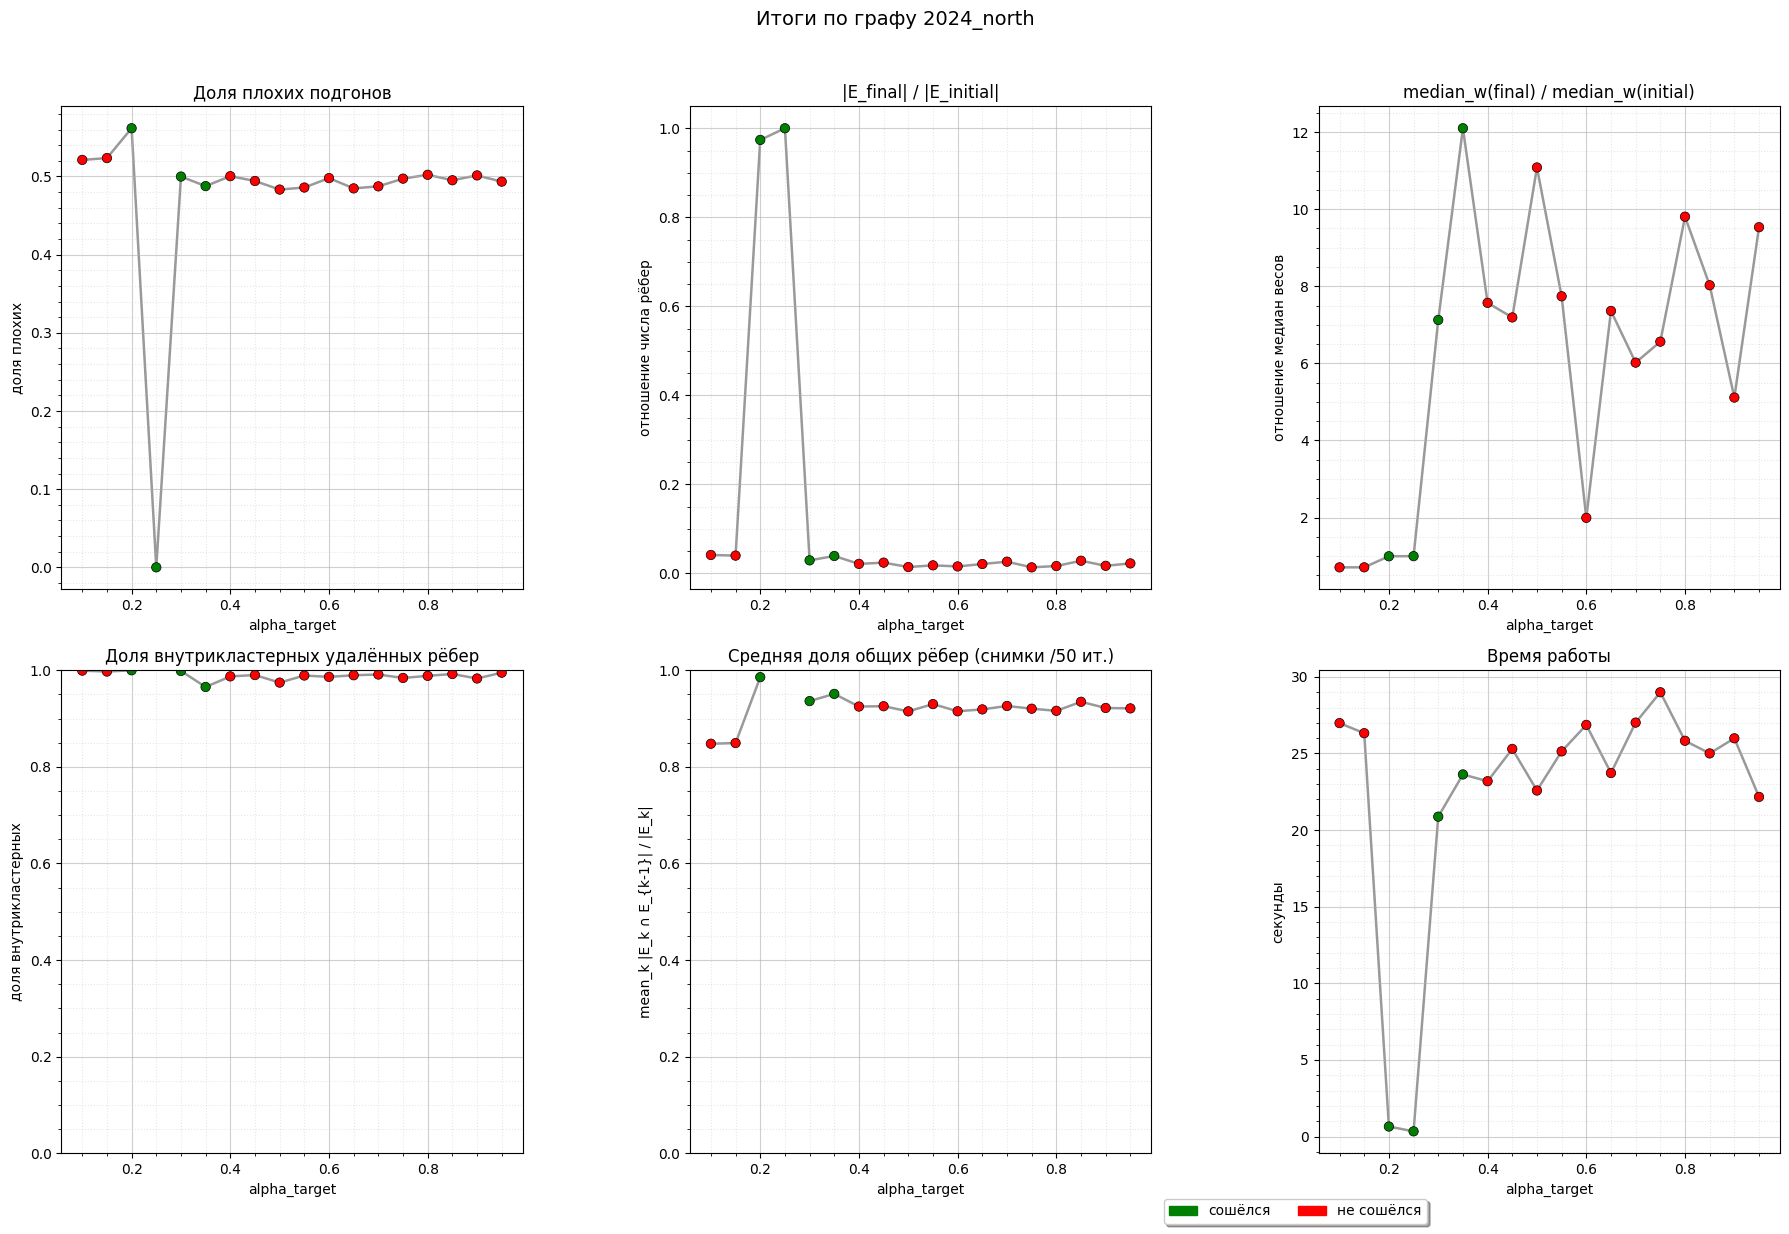

In [5]:
import numpy as np
from graphmcf.batch.runner import GraphMCFBatch

batch = GraphMCFBatch(small_graphs_for_mcf, graph_names=small_names)

alphas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
out = batch.run_mcf_over_per_graph(alphas, epsilon=0.025)

In [6]:
graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8', 'cola_t7']
Graphs_for_test = get_graphs(path_to_folder, graphs_for_test_names, True)

====================================   Анализ работы алгоритма для cola_t10  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 45.96 c
Итераций: 8300 (доля от максимума 8300 = 100.00%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.2099, final_alpha=0.2532, converged=False
Плохие шаги всего: 4138 (доля 0.50)
  — adversarial-плохих: 4138 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


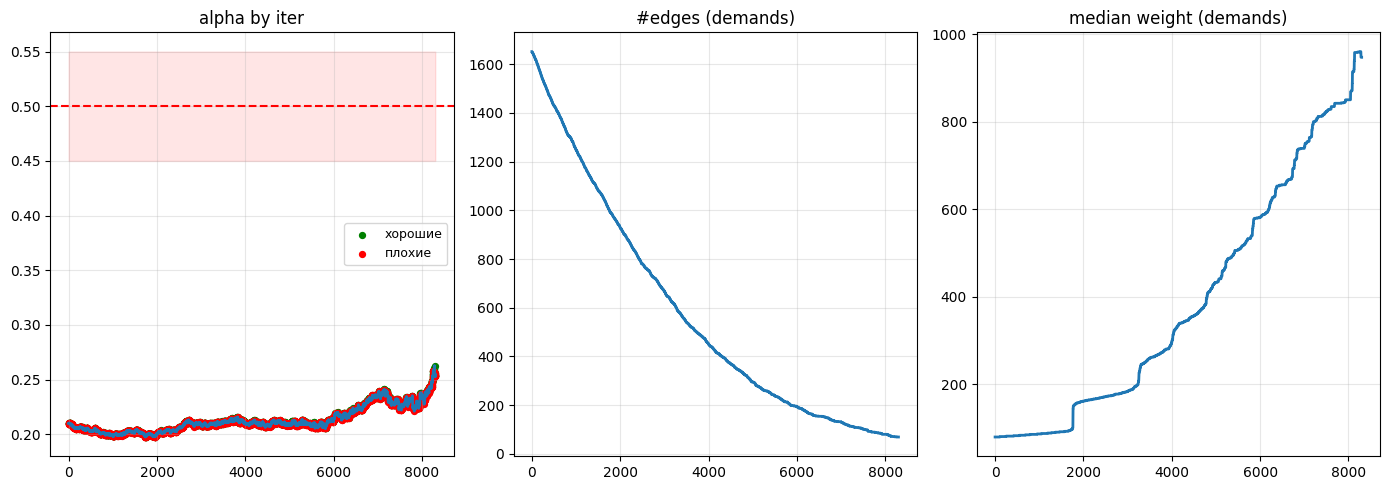

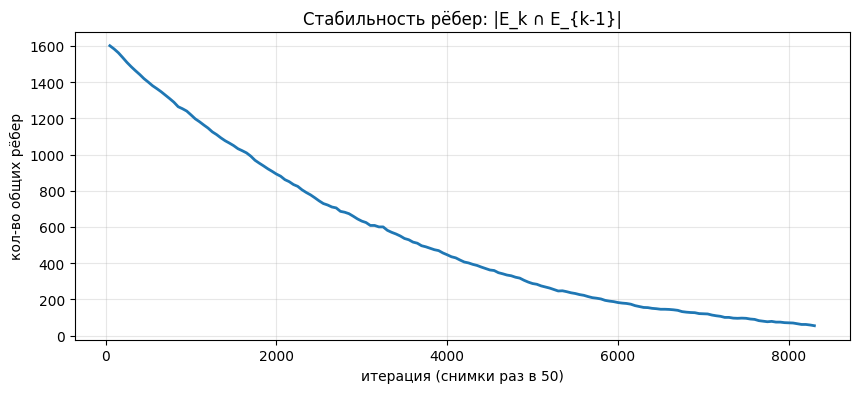

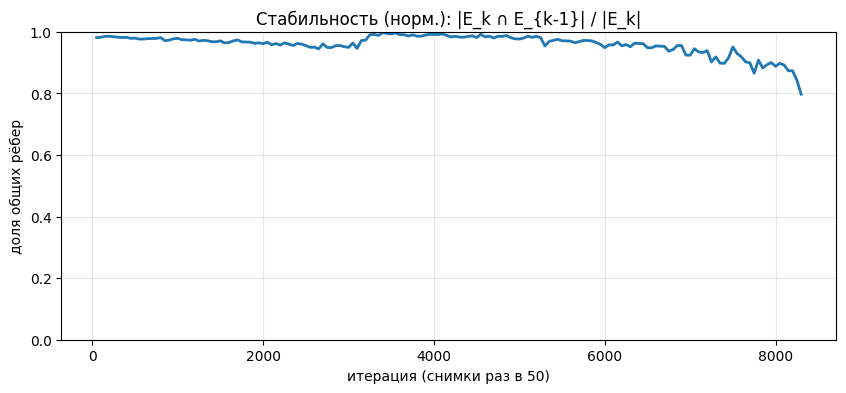

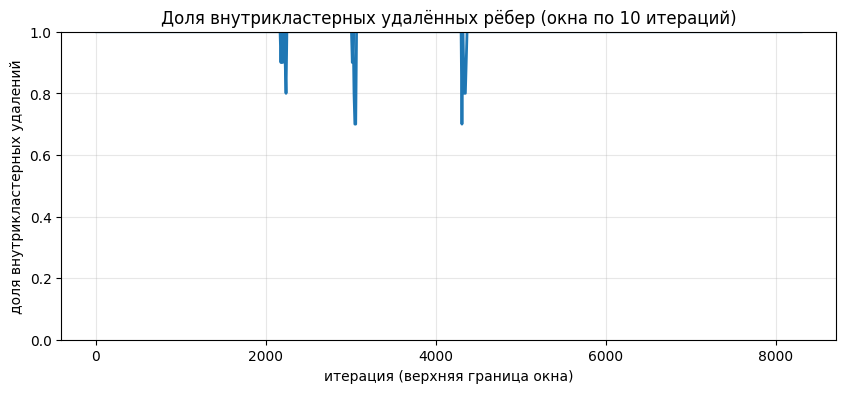

 метрика  initial  final
   edges     1652     69
median_w       80    947
  mean_w       80    766
   sum_w   131870  52862


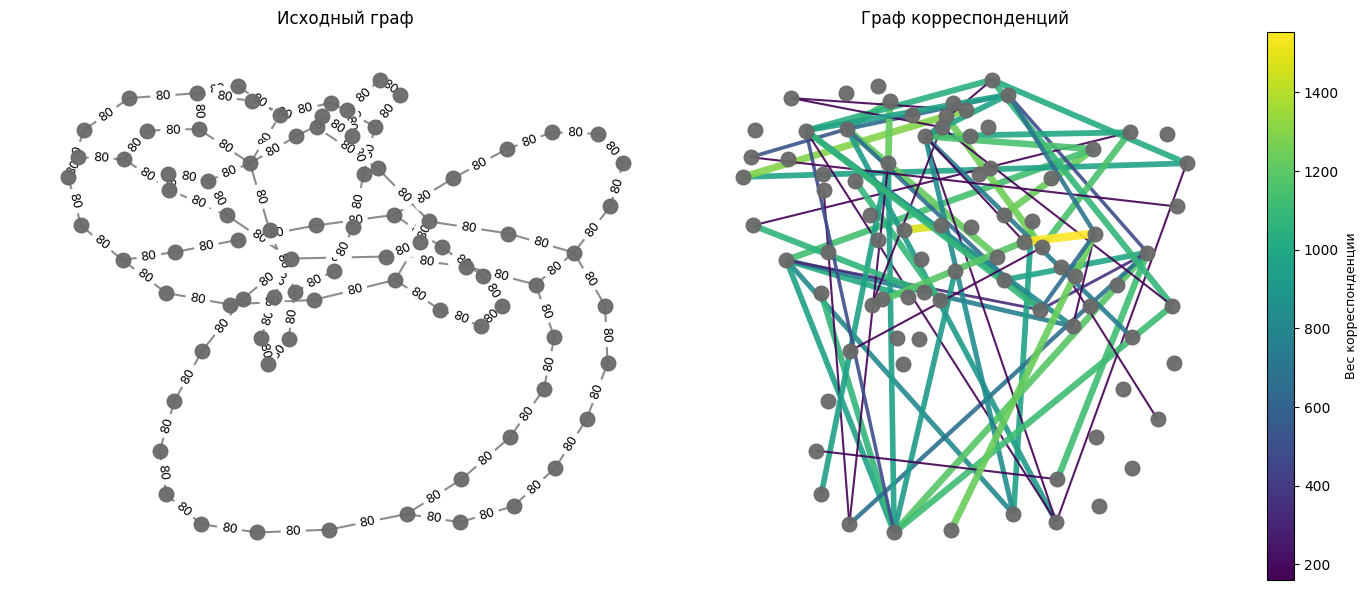

=================================== Конец анализа работы алгоритма для cola_t10 ===================================
====================================   Анализ работы алгоритма для cola_t3  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 0.44 c
Итераций: 243 (доля от максимума 2100 = 11.57%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.2595, final_alpha=0.4624, converged=True
Плохие шаги всего: 110 (доля 0.45)
  — adversarial-плохих: 110 (доля 0.45)
  — friendly-плохих:   0 (доля 0.00)


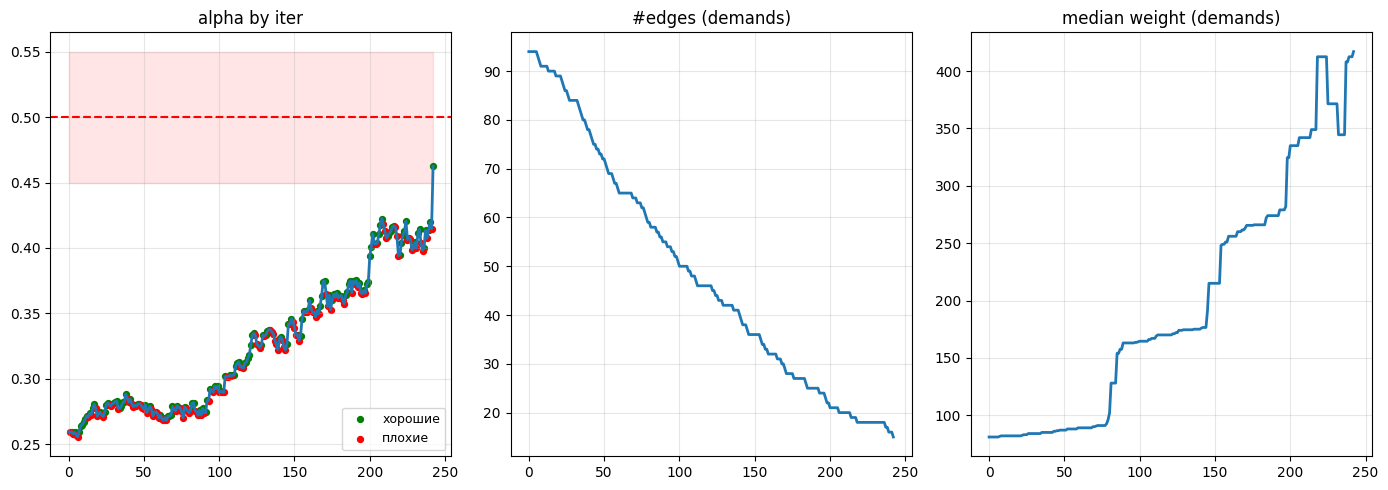

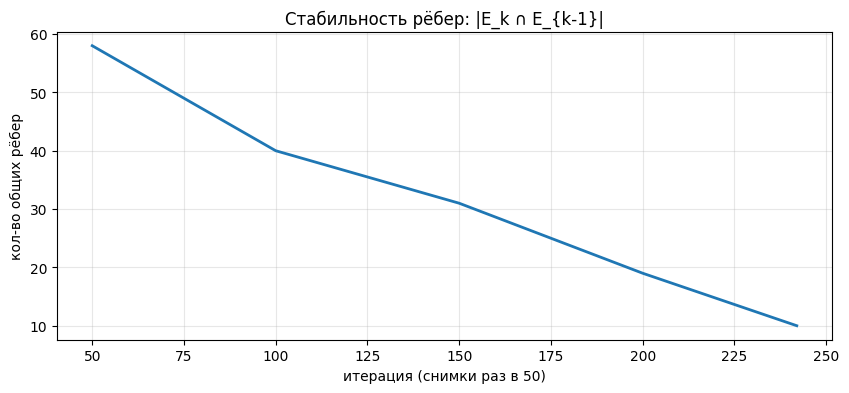

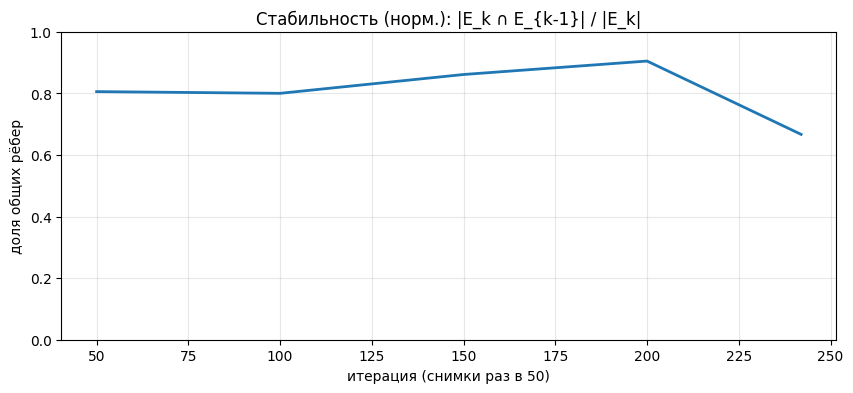

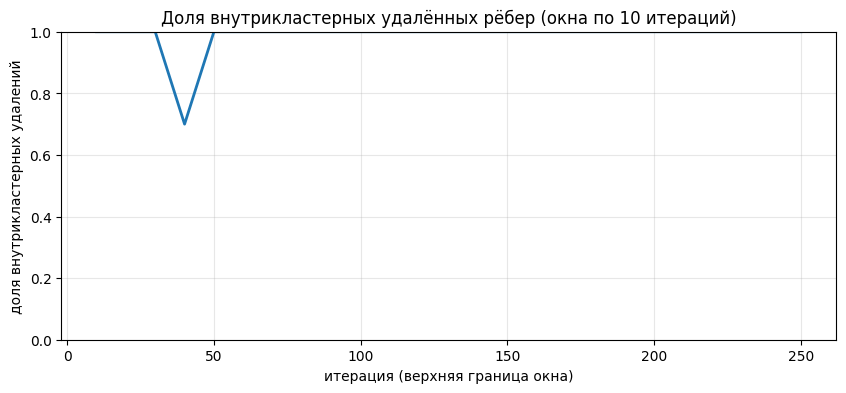

 метрика  initial  final
   edges       94     15
median_w       81    417
  mean_w       80    398
   sum_w     7551   5968


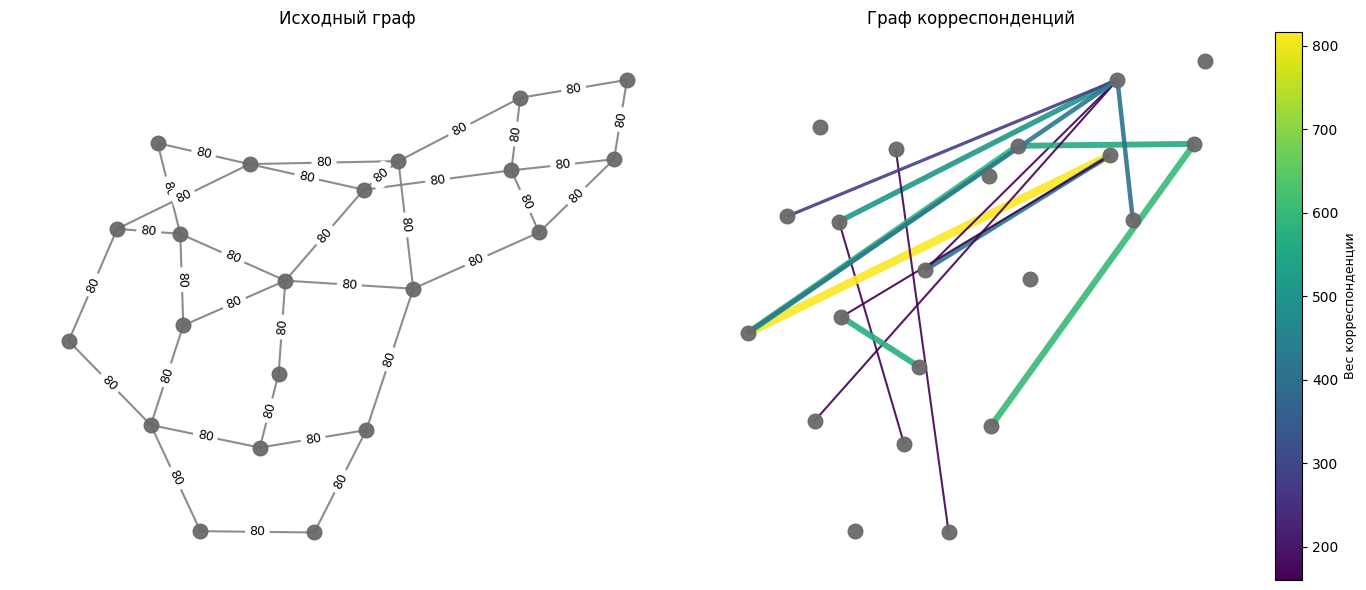

=================================== Конец анализа работы алгоритма для cola_t3 ===================================
====================================   Анализ работы алгоритма для cola_t7  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 329.57 c
Итераций: 16200 (доля от максимума 16200 = 100.00%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.1823, final_alpha=0.1875, converged=False
Плохие шаги всего: 8167 (доля 0.50)
  — adversarial-плохих: 8167 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


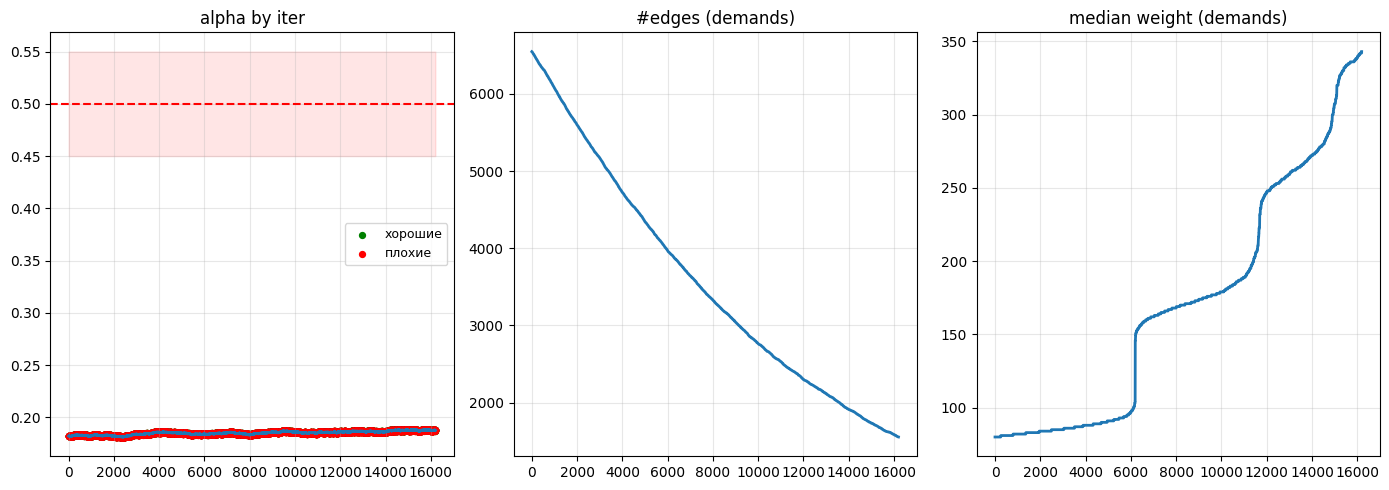

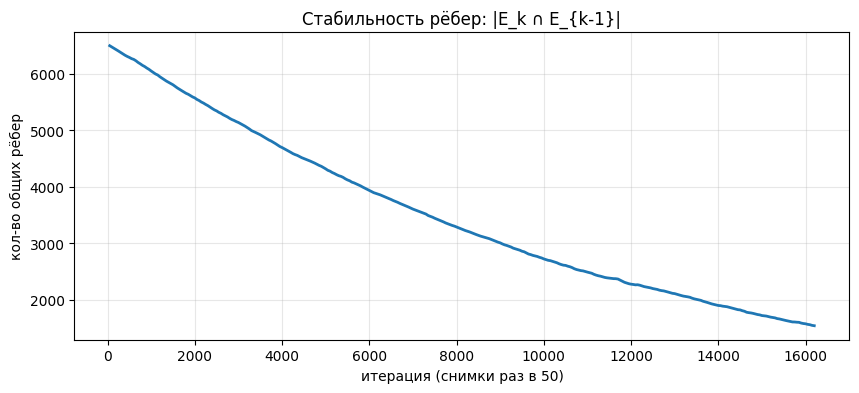

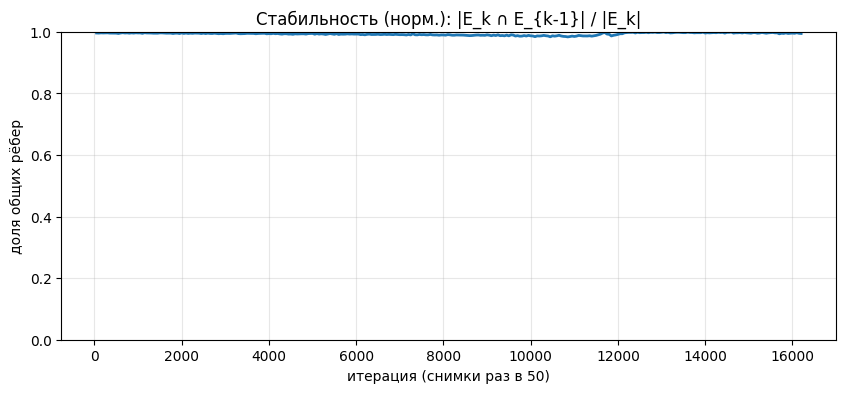

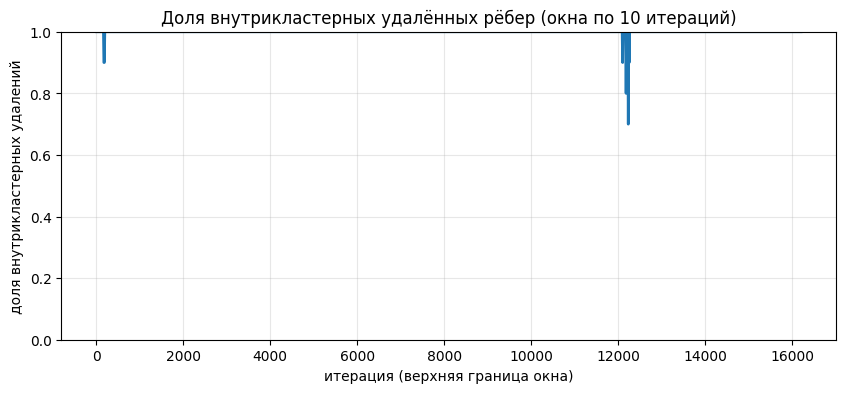

 метрика  initial  final
   edges     6548   1554
median_w       80    343
  mean_w       80    366
   sum_w   524252 569392


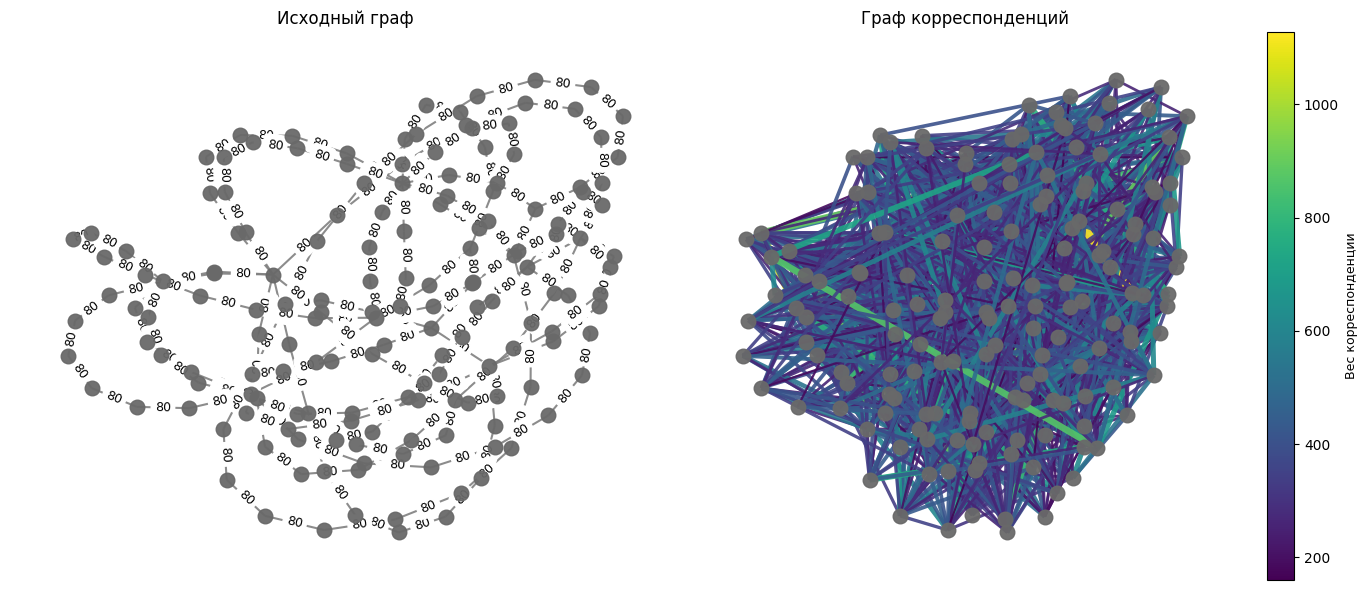

=================================== Конец анализа работы алгоритма для cola_t7 ===================================
====================================   Анализ работы алгоритма для cola_t8  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 11.84 c
Итераций: 3572 (доля от максимума 5400 = 66.15%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.3505, final_alpha=0.4511, converged=True
Плохие шаги всего: 1761 (доля 0.49)
  — adversarial-плохих: 1761 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


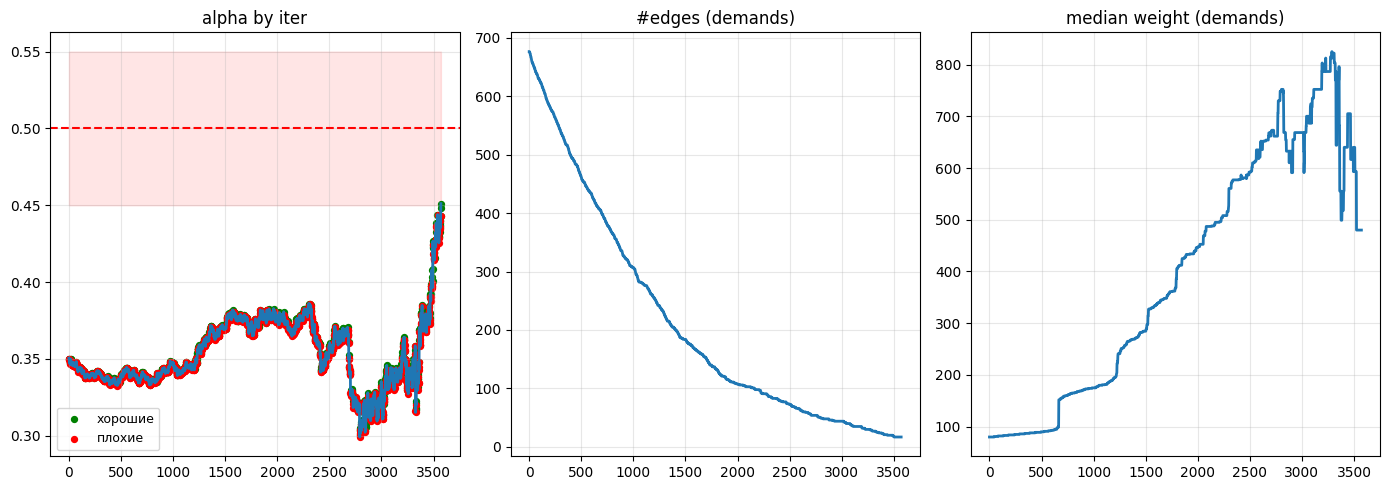

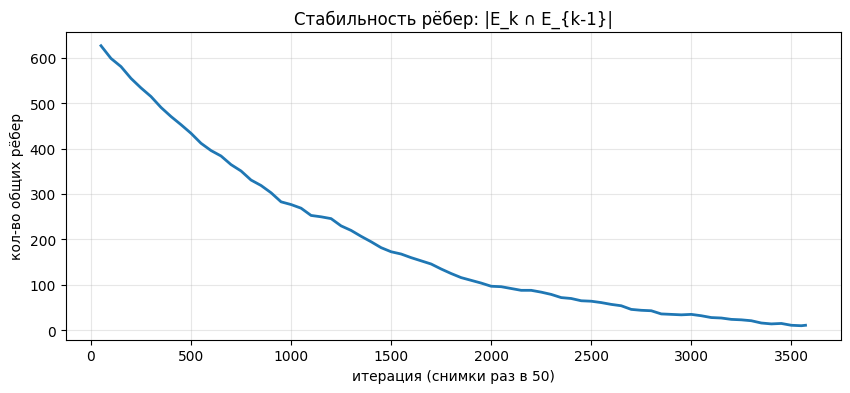

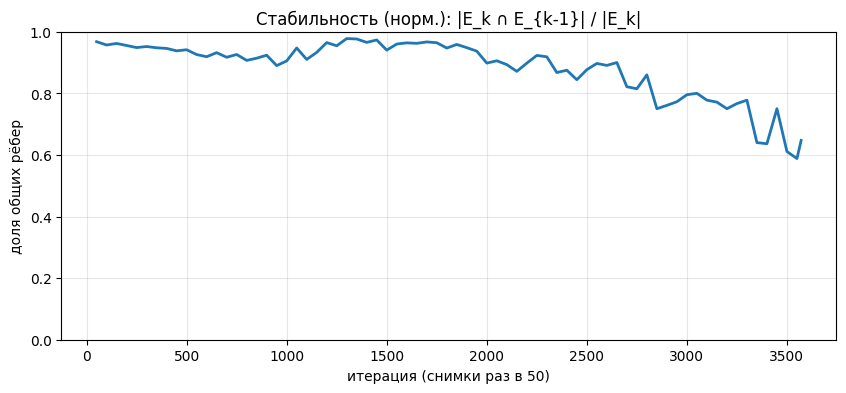

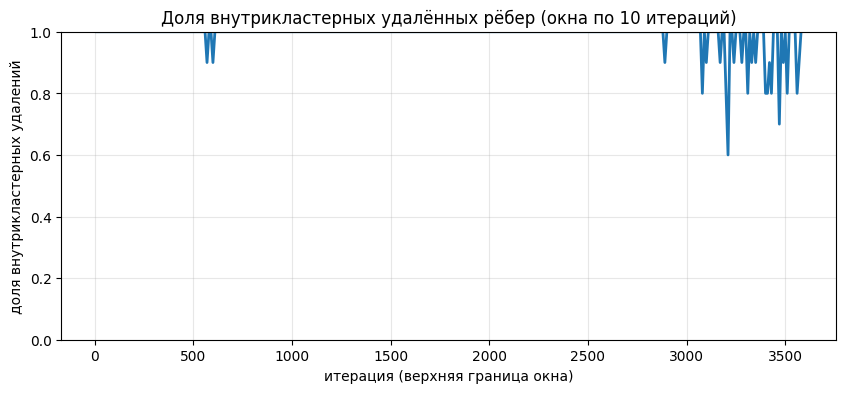

 метрика  initial  final
   edges      676     17
median_w       80    480
  mean_w       80    601
   sum_w    54089  10223


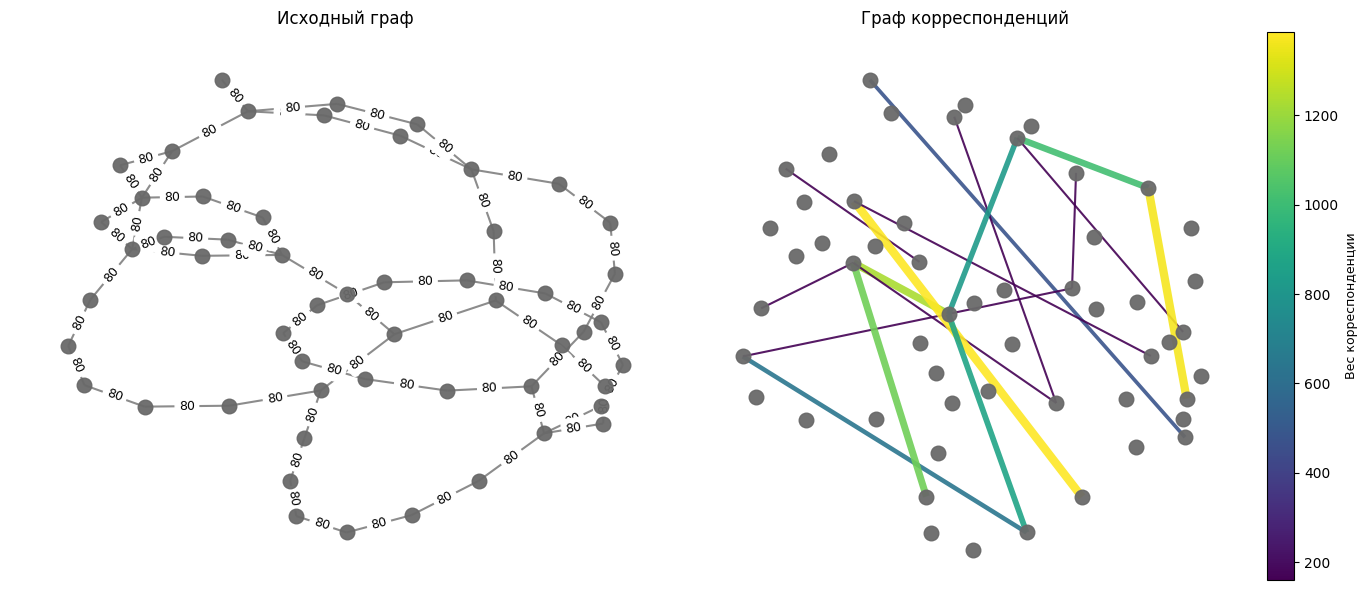

=================================== Конец анализа работы алгоритма для cola_t8 ===================================
====================================   Анализ работы алгоритма для cola_t2  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 1.25 c
Итераций: 1109 (доля от максимума 3200 = 34.66%)
alpha_target=0.5, epsilon=0.05
initial_alpha=0.1879, final_alpha=0.4564, converged=True
Плохие шаги всего: 525 (доля 0.47)
  — adversarial-плохих: 525 (доля 0.47)
  — friendly-плохих:   0 (доля 0.00)


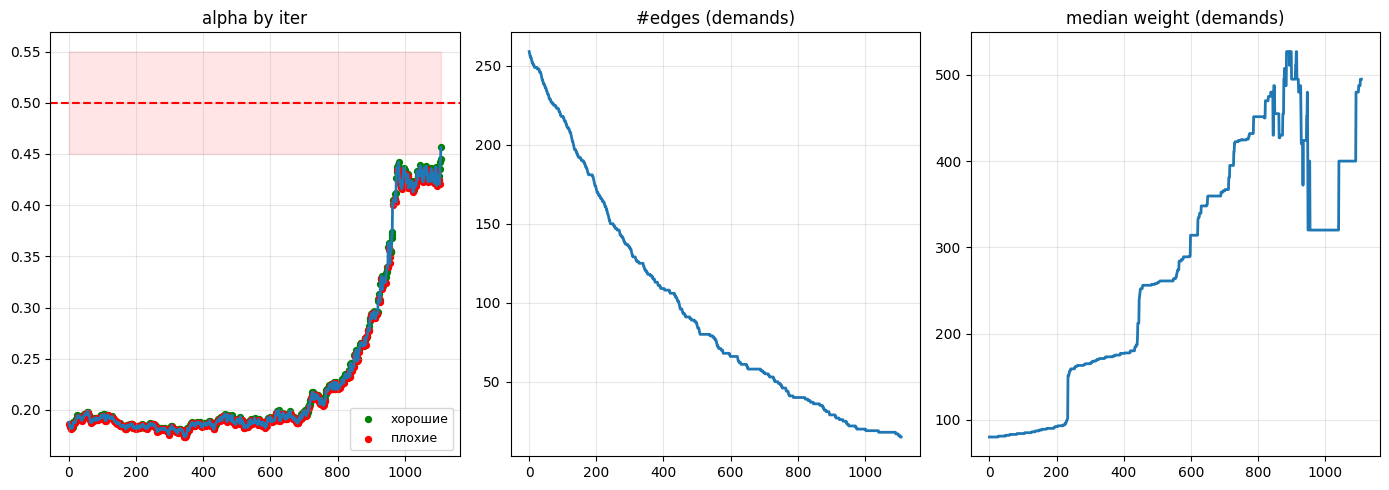

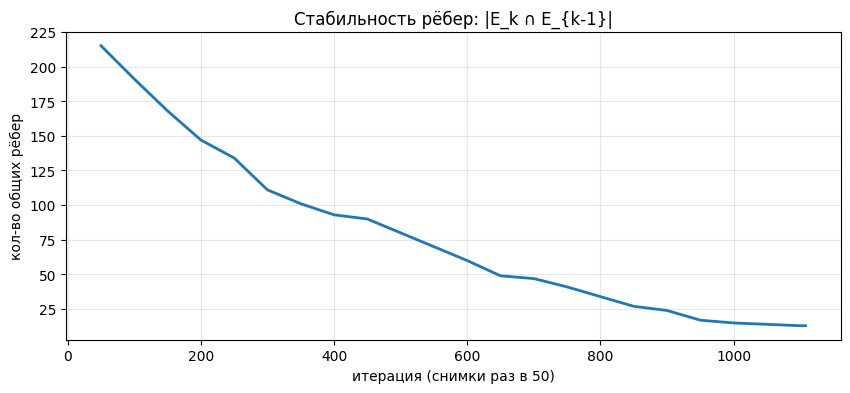

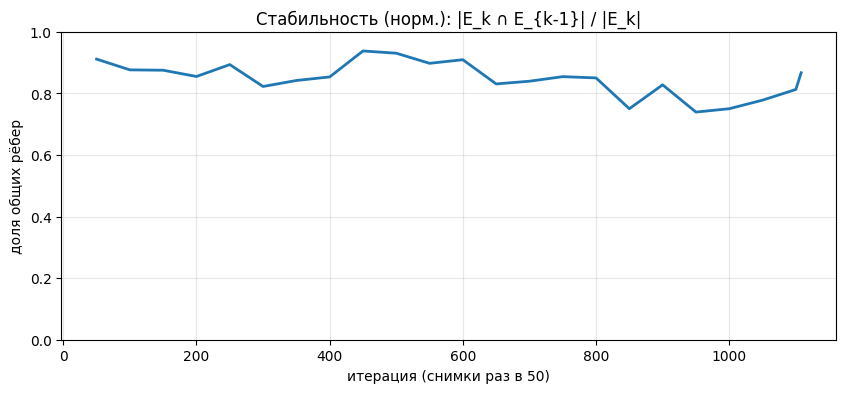

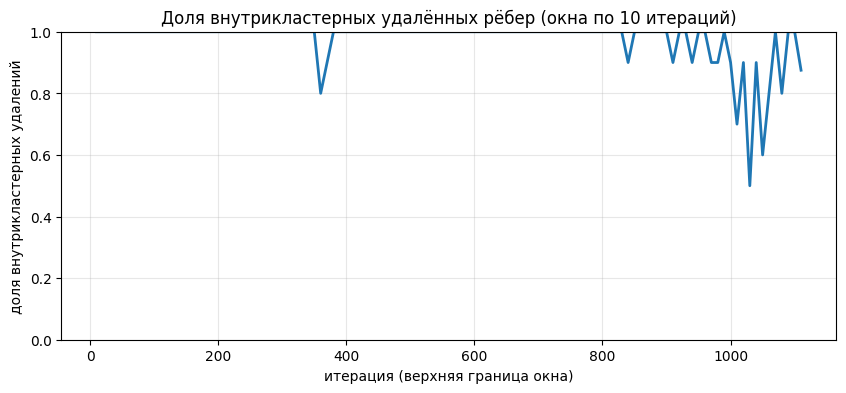

 метрика  initial  final
   edges      259     15
median_w       80    495
  mean_w       80    508
   sum_w    20695   7620


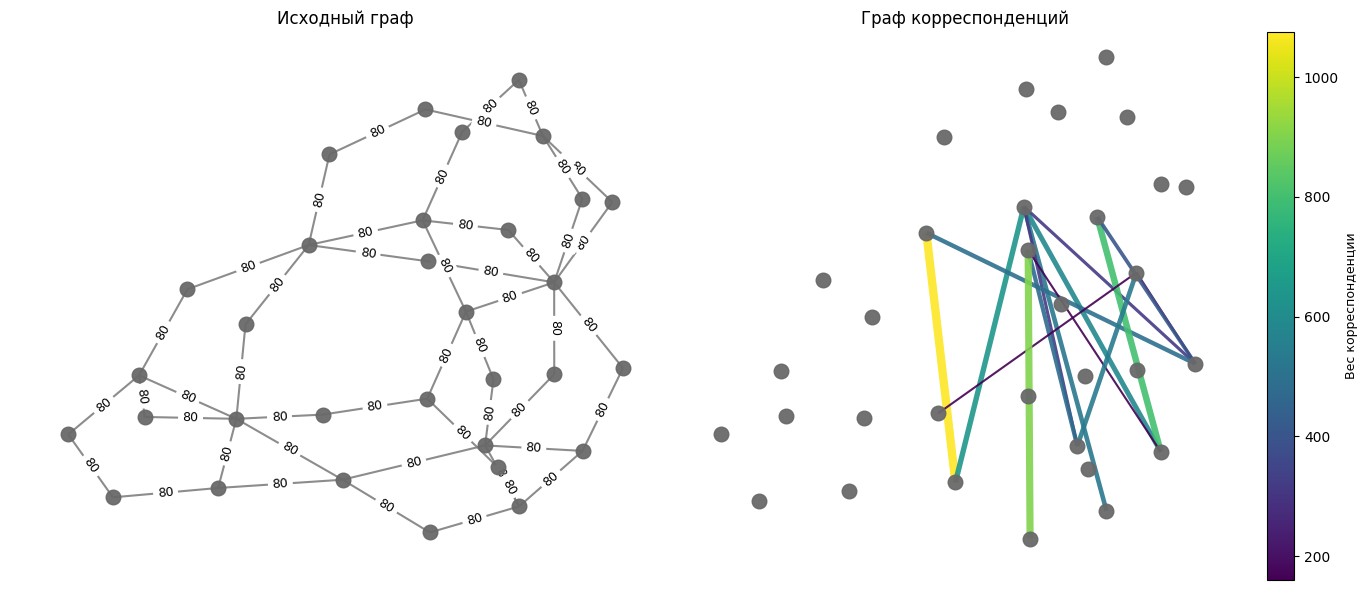

=================================== Конец анализа работы алгоритма для cola_t2 ===================================


In [9]:
import numpy as np
from graphmcf import GraphMCF
from graphmcf.demands import MCFGenerator
from graphmcf.analysis import analyze_simple

for name, graph in Graphs_for_test.items():
  graph_for_mcf = GraphMCF(graph['adj_matrix'])
  gen = MCFGenerator(epsilon=0.05)
  res = gen.generate(graph=graph_for_mcf, alpha_target=0.5, analysis_mode=None)
  print(f"====================================   Анализ работы алгоритма для {name}  ====================================")
  analyze_simple(graph_for_mcf, alpha_target=0.5, epsilon=0.05,
               start_time=res.start_time, end_time=res.end_time,
               alpha_history=res.alpha_history,
               edge_counts_history=res.edge_counts_history,
               median_weights_history=res.median_weights_history,
               edge_mask_history=res.edge_mask_history,
               edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
               removal_events=res.removal_events)
  graph_for_mcf.visualise_with_demands()
  print(f"=================================== Конец анализа работы алгоритма для {name} ===================================")